In [1]:
import numpy as np
import matplotlib.pyplot as plt

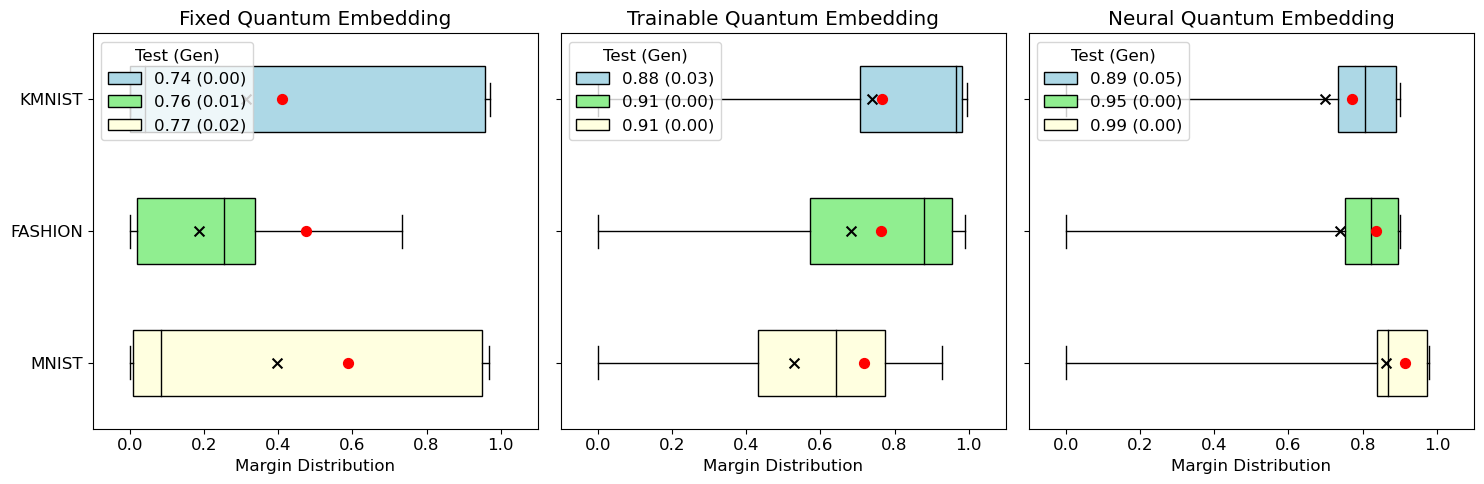

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def get_generalization_gap(path):
    with open(path + "results.txt", 'r') as file:
        lines = file.readlines()
        for line in lines:
            if "Generalization Gap" in line:
                return float(line.split(":")[1].strip())
    return None

def get_margin_mean(path):
    return np.load(path + "margin_mean.npy")

def get_trace_distance(path):
    return np.load(path + "trace_distance.npy")

def get_test_accuracy(path):
    with open(path + "results.txt", 'r') as file:
        lines = file.readlines()
        for line in lines:
            if "Test Accuracy" in line:
                return float(line.split(":")[1].strip())
    return None

def get_margin_boxplot(experiment):
    classifier_list = ["IQPVariationalClassifier", "TQEClassifier", "PCA_NQEClassifier"]
    title_list = ["Fixed Quantum Embedding", "Trainable Quantum Embedding", "Neural Quantum Embedding"]
    data_sets = ["mnist", "fashion", "kmnist"]

    # Initialize dictionaries to store margin data, margin mean, and trace distance values for a single experiment
    margin_data = {clf: {ds: None for ds in data_sets} for clf in classifier_list}
    margin_means = {clf: {ds: None for ds in data_sets} for clf in classifier_list}
    trace_distances = {clf: {ds: None for ds in data_sets} for clf in classifier_list}

    # Loop over each classifier and dataset to gather margin data for the single experiment
    for classifier in classifier_list:
        for data in data_sets:
            path = f"../results/{classifier}/{data}/{experiment}exp/"
            margin_data[classifier][data] = np.load(path + "margin_boxplot.npy")
            margin_means[classifier][data] = get_margin_mean(path)
            trace_distances[classifier][data] = get_trace_distance(path)

    # Plotting
    fig, axes = plt.subplots(1, len(classifier_list), figsize=(15, 5))
    plt.rcParams.update({'font.size': 12})
    position = np.array([0, 1, 2])

    # Custom properties for the median line in the boxplot
    medianprops = dict(color='black', linewidth=1)

    for i, classifier in enumerate(classifier_list):
        bp1 = axes[i].boxplot(margin_data[classifier]['mnist'], positions=[0], widths=0.5, patch_artist=True, 
                              boxprops=dict(facecolor="lightyellow"), vert=False, showfliers=False, 
                              medianprops=medianprops, whis=[0, 100])
        bp2 = axes[i].boxplot(margin_data[classifier]['fashion'], positions=[1], widths=0.5, patch_artist=True, 
                              boxprops=dict(facecolor="lightgreen"), vert=False, showfliers=False, 
                              medianprops=medianprops, whis=[0, 100])
        bp3 = axes[i].boxplot(margin_data[classifier]['kmnist'], positions=[2], widths=0.5, patch_artist=True, 
                              boxprops=dict(facecolor="lightblue"), vert=False, showfliers=False, 
                              medianprops=medianprops, whis=[0, 100])
        
        # Plot the mean of margin means as a single marker on the x-axis with larger size
        axes[i].scatter(margin_means[classifier]['mnist'], 0, color="black", marker="x", s=50, zorder=3, label=f'MNIST Mean: {margin_means[classifier]["mnist"]:.3f}')
        axes[i].scatter(margin_means[classifier]['fashion'], 1, color="black", marker="x", s=50, zorder=3, label=f'Fashion Mean: {margin_means[classifier]["fashion"]:.3f}')
        axes[i].scatter(margin_means[classifier]['kmnist'], 2, color="black", marker="x", s=50, zorder=3, label=f'KMNIST Mean: {margin_means[classifier]["kmnist"]:.3f}')
        
        # Plot the trace distance as a red circle
        axes[i].scatter(trace_distances[classifier]['mnist'], 0, color="red", marker="o", s=50, zorder=3, label=f'MNIST Trace: {trace_distances[classifier]["mnist"]:.3f}')
        axes[i].scatter(trace_distances[classifier]['fashion'], 1, color="red", marker="o", s=50, zorder=3, label=f'Fashion Trace: {trace_distances[classifier]["fashion"]:.3f}')
        axes[i].scatter(trace_distances[classifier]['kmnist'], 2, color="red", marker="o", s=50, zorder=3, label=f'KMNIST Trace: {trace_distances[classifier]["kmnist"]:.3f}')
        
        axes[i].set_xlabel("Margin Distribution")
        axes[i].set_xlim(-0.1, 1.1)
        axes[i].set_yticks([0, 1, 2], ["MNIST", "FASHION", "KMNIST"])
        axes[i].set_title(f"{title_list[i]}")
        
        if i != 0:
            axes[i].set_yticklabels([])  # Remove y-axis labels for all but the first plot

        # Read test accuracies and generalization gaps for the current experiment
        mnist_test_acc = get_test_accuracy(f"../results/{classifier}/mnist/{experiment}exp/")
        fashion_test_acc = get_test_accuracy(f"../results/{classifier}/fashion/{experiment}exp/")
        kmnist_test_acc = get_test_accuracy(f"../results/{classifier}/kmnist/{experiment}exp/")

        mnist_gen_gap = get_generalization_gap(f"../results/{classifier}/mnist/{experiment}exp/")
        fashion_gen_gap = get_generalization_gap(f"../results/{classifier}/fashion/{experiment}exp/")
        kmnist_gen_gap = get_generalization_gap(f"../results/{classifier}/kmnist/{experiment}exp/")
        axes[i].legend([bp3["boxes"][0], bp2["boxes"][0], bp1["boxes"][0]], 
                    [f'{max(0, kmnist_test_acc):.2f} ({max(0, kmnist_gen_gap):.2f})', 
                        f'{max(0, fashion_test_acc):.2f} ({max(0, fashion_gen_gap):.2f})', 
                        f'{max(0, mnist_test_acc):.2f} ({max(0, mnist_gen_gap):.2f})'], 
                    loc='upper left', title="Test (Gen)")
    
    plt.tight_layout()
    plt.savefig("margin_boxplot.pdf")
    plt.show()

# Example usage
experiment = 1  # Single experiment index
get_margin_boxplot(experiment)
